In [65]:
import csv
import pandas as pd
from collections import Counter 
from itertools import chain, combinations
import random

In [66]:
def freq_itemset_finder(iterat, freq_itemset, transaction_set, min_support_perct):
    # Number of items in the transaction set
    lenght = len(transaction_set)
    item_set=[] 
    if(iterat < 1): # Two item sets
        item_set = [tuple(sorted((item1,item2))) for item1 in freq_itemset for item2 in freq_itemset if item1 != item2]
        item_set= list(set(item_set))
    else: # For multiple itemsets
        for i in range(0,len(freq_itemset)):
            f1 = freq_itemset[i][:-(len(freq_itemset[i])-1)]
            for j in range(i+1,len(freq_itemset)):
                f2 = freq_itemset[j][:-(len(freq_itemset[j])-1)]
                if(f1==f2): # creating new itemset only if top n-1 itemsets are common between 2 item sets
                    item_set.append(tuple(sorted(tuple(set(freq_itemset[i]+freq_itemset[j])))))
        
        item_set= list(set(item_set))
    # finding the frequency of new formed itemsets
    new_freq_itemset = []
    for item in item_set:
        j=0
        for outer in transaction_set:
            if(set(item).issubset(outer)): # if the item set is a subset of transction set
                j=j+1
        if(((j/lenght)*100)>min_support_perct): # final count of frequent items's support is > min_threshold
            new_freq_itemset.append(item) # Its a frequent item set
            
    return(list(set(new_freq_itemset))) # new formed frequent item set

# to find the support count for one itemset
def getSupport(item,transaction_list):
    
    lenght = len(transaction_list)
    j=0
    for outer in transaction_list:
        if(set(item).issubset(outer)):
            j=j+1
    return (j/lenght)

# Creating Subsets/for a given set
def powerset(iterable):
    
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(1,len(s)+1))


In [111]:
# Apriori Algorithm implementation

def Apriori_algo(min_support_perct, minConfidence, transaction_list ):
    # generating frequent item set of length 1
    result_count = dict(Counter(i for sub in transaction_list for i in set(sub)))
    # Number of items in the transaction set
    lenght = len(transaction_list)
    result_support = {key:round((value/lenght)*100,4) for key, value in result_count.items()}
    # Finding the frequent items greater than min_supportthreshold
    frequent_1_itemset = [key for key, value in result_support.items() if value >=min_support_perct]
 
    inc = 1
    freq_itemset = frequent_1_itemset
    freq_dic = {inc:freq_itemset}

    # Loop over all length till freq_itemset based on support has less than or equal to 1 item 
    while(len(freq_itemset)>=2): 
        freq_itemset = freq_itemset_finder(iterat=inc-1, freq_itemset=freq_itemset, transaction_set=transaction_list, min_support_perct=min_support_perct)
        inc = inc+1
        # Dectionary for each length frequent itemset
        freq_dic.update({inc:freq_itemset})

    return(freq_dic) # frequent item sets as a dictionary for each length of the itemset.


# finding confidence and framing rules based on confidence 
def Rule_formation(freq_dic, minConfidence,transaction_list):
    Rules = []
    index = [i for i in freq_dic]

    for i in index[:-1]:
        largeSet = freq_dic[i] 
        for value in largeSet:
            if(type(value)==int):
                value = [value]
            # creating all the subsets
            subsets = [x for x in set(powerset(value))]
            for element in subsets:
                element = set(element)
                val_set = set(value)
                # Subracting the superset to the subset (i.e L= {Beer, Diapers} f= {Beer} L-f = {Diapers})
                remain = val_set.difference(element)
                # If there exist a diffence from superset then calculate confidence
                if len(remain) > 0:
                    # Confidence = Support (L)/Support (f)
                    confidence = (getSupport(val_set,transaction_list)/getSupport(element,transaction_list))*100
                    #support
                    main_support = getSupport(val_set,transaction_list)
                    #lift = confidence/ support(L-f)
                    lift = confidence/getSupport(remain,transaction_list)
                    if confidence >= minConfidence:
                        Rules.append(((tuple(element), tuple(remain)),
                                           confidence,lift,main_support))
    return(Rules)

# For returning dictionary to list
def freq_itemset_list(freq_dic):
    index = [i for i in freq_dic]
    freq_item_set = sorted(freq_dic[1])
    for i in index[1:-1]:
        freq_item_set = freq_item_set+sorted(freq_dic[i])
    return(freq_item_set)

def randomized_algo(perct, min_support_perct, minConfidence, transaction_list):
    # perct : The percentage of samples from the main transaction list 
    # min_support_perct : min support threshold in percentage
    num_samples = round(len(transaction_list) * perct/100)
    #Using random samples we are choosing the percentage that we need for randomized algorithm
    ran_sample  = random.sample(transaction_list,num_samples)
    #Apriori algorithm to generate frequent item set
    freq_dic = Apriori_algo(min_support_perct, minConfidence , ran_sample)
    
    # returning frequent item sets and sample set
    return(freq_dic,ran_sample )

def print_rules(Rules):
    for i in range(len(Rules)):
        print(set(Rules[i][0][0]),"\t-->\t",set(Rules[i][0][1]),"\t C: ",Rules[i][1],"\t L: ",Rules[i][2],"\t S: ",Rules[i][3],)

In [5]:
# Reading the data set
with open('itemset_data.csv', newline='') as csvfile:
    basket = csv.reader(csvfile)
    transaction_list = []
    for row in basket:
        # To remove the empty cells
        inner_list = [int(v) for v in row if v != '']
        transaction_list.append(inner_list)



In [204]:
# min support threshold = 1 %
print("APRIORI ALGORITHM min support threshold = 1 % ")
print("----------------------------------------------")
import time
start = time.process_time()

freq_dic_Apriori = Apriori_algo(min_support_perct = 1, minConfidence = 5, transaction_list = transaction_list)

end = time.process_time()  
print("Total time taken: ",end - start," sec")
print("Number of frequent item set: ",len(freq_itemset_list(freq_dic_Apriori)))
Rule_Apriori = Rule_formation(freq_dic_Apriori, minConfidence=5 ,transaction_list = transaction_list)


# min support threshold = 1% sample size = 10%
print()
print()
print("SIMPLE RANDOM ALGORITHM min support threshold = 1 % and sample size = 10%")
print("-------------------------------------------------------------------------")
import time
start = time.process_time()

freq_dic_randomized_10, ran_sample = randomized_algo(perct= 10, min_support_perct = 1, minConfidence = 5, transaction_list= transaction_list)

end = time.process_time() 
print("Total time taken: ",end - start," sec")
print("Number of frequent item set: ",len(freq_itemset_list(freq_dic_randomized_10)))
Rules_randomized_10 = Rule_formation(freq_dic = freq_dic_randomized_10 , minConfidence = 5 , transaction_list = ran_sample)


# min support threshold = 1% sample size = 20%
print()
print()
print("SIMPLE RANDOM ALGORITHM min support threshold = 1 % and sample size = 20%")
print("-------------------------------------------------------------------------")
import time
start = time.process_time()

freq_dic_randomized_20,ran_sample = randomized_algo(perct= 20, min_support_perct = 1, minConfidence = 5, transaction_list=transaction_list)

end = time.process_time() 
print("Total time taken: ",end - start," sec")
print("Number of frequent item set: ",len(freq_itemset_list(freq_dic_randomized_20)))
Rules_randomized_20 = Rule_formation(freq_dic = freq_dic_randomized_20 , minConfidence = 5 , transaction_list = ran_sample)

# min support threshold = 1% sample size = 30%
print()
print()
print("SIMPLE RANDOM ALGORITHM min support threshold = 1 % and sample size = 30%")
print("-------------------------------------------------------------------------")
import time
start = time.process_time()

freq_dic_randomized_30,ran_sample = randomized_algo(perct= 30, min_support_perct = 1, minConfidence = 5, transaction_list=transaction_list)

end = time.process_time() 
print("Total time taken: ",end - start," sec")
print("Number of frequent item set: ",len(freq_itemset_list(freq_dic_randomized_30)))
Rules_randomized_30 = Rule_formation(freq_dic = freq_dic_randomized_30 , minConfidence = 5 , transaction_list = ran_sample)


APRIORI ALGORITHM min support threshold = 1 % 
----------------------------------------------
Total time taken:  520.609375  sec
Number of frequent item set:  159


SIMPLE RANDOM ALGORITHM min support threshold = 1 % and sample size = 10%
-------------------------------------------------------------------------
Total time taken:  60.703125  sec
Number of frequent item set:  156


SIMPLE RANDOM ALGORITHM min support threshold = 1 % and sample size = 20%
-------------------------------------------------------------------------
Total time taken:  142.296875  sec
Number of frequent item set:  162


SIMPLE RANDOM ALGORITHM min support threshold = 1 % and sample size = 30%
-------------------------------------------------------------------------
Total time taken:  193.640625  sec
Number of frequent item set:  165


In [225]:
# min support threshold = 2 %
print("APRIORI ALGORITHM min support threshold = 2 % ")
print("----------------------------------------------")
import time
start = time.process_time()

freq_dic_Apriori = Apriori_algo(min_support_perct = 2, minConfidence = 5, transaction_list = transaction_list)

end = time.process_time()  
print("Total time taken: ",end - start," sec")
print("Number of frequent item set: ",len(freq_itemset_list(freq_dic_Apriori)))
Rule_Apriori = Rule_formation(freq_dic_Apriori, minConfidence=5 ,transaction_list = transaction_list)

# min support threshold = 2% sample size = 10%
print()
print()
print("SIMPLE RANDOM ALGORITHM min support threshold = 2 % and sample size = 10%")
print("-------------------------------------------------------------------------")
import time
start = time.process_time()

freq_dic_randomized_10,ran_sample = randomized_algo(perct= 10, min_support_perct = 2, minConfidence = 5, transaction_list= transaction_list)

end = time.process_time() 
print("Total time taken: ",end - start," sec")
print("Number of frequent item set: ",len(freq_itemset_list(freq_dic_randomized_10)))
Rules_randomized_10 = Rule_formation(freq_dic = freq_dic_randomized_10 , minConfidence = 5 , transaction_list = ran_sample)


# min support threshold = 2% sample size = 20%
print()
print()
print("SIMPLE RANDOM ALGORITHM min support threshold = 2 % and sample size = 20%")
print("-------------------------------------------------------------------------")
import time
start = time.process_time()

freq_dic_randomized_20,ran_sample = randomized_algo(perct= 20, min_support_perct = 2, minConfidence = 5, transaction_list=transaction_list)

end = time.process_time() 
print("Total time taken: ",end - start," sec")
print("Number of frequent item set: ",len(freq_itemset_list(freq_dic_randomized_20)))
Rules_randomized_20 = Rule_formation(freq_dic = freq_dic_randomized_20 , minConfidence = 5 , transaction_list = ran_sample)


# min support threshold = 2% sample size = 30%
print()
print()
print("SIMPLE RANDOM ALGORITHM min support threshold = 2 % and sample size = 30%")
print("-------------------------------------------------------------------------")
import time
start = time.process_time()

freq_dic_randomized_30,ran_sample = randomized_algo(perct= 30, min_support_perct = 2, minConfidence = 5, transaction_list=transaction_list)

end = time.process_time() 
print("Total time taken: ",end - start," sec")
print("Number of frequent item set: ",len(freq_itemset_list(freq_dic_randomized_30)))
Rules_randomized_30 = Rule_formation(freq_dic = freq_dic_randomized_30 , minConfidence = 5 , transaction_list = ran_sample)


APRIORI ALGORITHM min support threshold = 2 % 
----------------------------------------------
Total time taken:  45.53125  sec
Number of frequent item set:  54


SIMPLE RANDOM ALGORITHM min support threshold = 2 % and sample size = 10%
-------------------------------------------------------------------------
Total time taken:  4.84375  sec
Number of frequent item set:  55


SIMPLE RANDOM ALGORITHM min support threshold = 2 % and sample size = 20%
-------------------------------------------------------------------------
Total time taken:  11.4375  sec
Number of frequent item set:  55


SIMPLE RANDOM ALGORITHM min support threshold = 2 % and sample size = 30%
-------------------------------------------------------------------------
Total time taken:  15.3125  sec
Number of frequent item set:  55


In [218]:
# min support threshold = 5 %
print("APRIORI ALGORITHM min support threshold = 5 % ")
print("----------------------------------------------")
import time
start = time.process_time()

freq_dic_Apriori = Apriori_algo(min_support_perct = 5, minConfidence = 5, transaction_list = transaction_list)

end = time.process_time()  
print("Total time taken: ",end - start)
print("Number of frequent item set: ",len(freq_itemset_list(freq_dic_Apriori)))
Rule_Apriori = Rule_formation(freq_dic_Apriori, minConfidence=5 ,transaction_list = transaction_list)

# min support threshold = 5% sample size = 10%
print()
print()
print("SIMPLE RANDOM ALGORITHM min support threshold = 5 % and sample size = 10%")
print("-------------------------------------------------------------------------")
import time
start = time.process_time()

freq_dic_randomized_10,ran_sample = randomized_algo(perct= 10, min_support_perct = 5, minConfidence = 5, transaction_list= transaction_list)

end = time.process_time() 
print("Total time taken: ",end - start)
print("Number of frequent item set: ",len(freq_itemset_list(freq_dic_randomized_10)))
Rules_randomized_10 = Rule_formation(freq_dic = freq_dic_randomized_10 , minConfidence = 5 , transaction_list = ran_sample)


# min support threshold = 5% sample size = 20%
print()
print()
print("SIMPLE RANDOM ALGORITHM min support threshold = 5 % and sample size = 20%")
print("-------------------------------------------------------------------------")
import time
start = time.process_time()

freq_dic_randomized_20,ran_sample = randomized_algo(perct= 20, min_support_perct = 5, minConfidence = 5, transaction_list=transaction_list)

end = time.process_time() 
print("Total time taken: ",end - start)
print("Number of frequent item set: ",len(freq_itemset_list(freq_dic_randomized_20)))
Rules_randomized_20 = Rule_formation(freq_dic = freq_dic_randomized_20 , minConfidence = 5 , transaction_list = ran_sample)



# min support threshold = 5% sample size = 30%
print()
print()
print("SIMPLE RANDOM ALGORITHM min support threshold = 5 % and sample size = 30%")
print("-------------------------------------------------------------------------")
import time
start = time.process_time()

freq_dic_randomized_30,ran_sample = randomized_algo(perct= 30, min_support_perct = 5, minConfidence = 5, transaction_list=transaction_list)

end = time.process_time() 
print("Total time taken: ",end - start)
print("Number of frequent item set: ",len(freq_itemset_list(freq_dic_randomized_30)))
Rules_randomized_30 = Rule_formation(freq_dic = freq_dic_randomized_30 , minConfidence = 5 , transaction_list = ran_sample)


APRIORI ALGORITHM min support threshold = 5 % 
----------------------------------------------
Total time taken:  3.875
Number of frequent item set:  16


SIMPLE RANDOM ALGORITHM min support threshold = 5 % and sample size = 10%
-------------------------------------------------------------------------
Total time taken:  0.5
Number of frequent item set:  16


SIMPLE RANDOM ALGORITHM min support threshold = 5 % and sample size = 20%
-------------------------------------------------------------------------
Total time taken:  0.6875
Number of frequent item set:  15


SIMPLE RANDOM ALGORITHM min support threshold = 5 % and sample size = 30%
-------------------------------------------------------------------------
Total time taken:  1.109375
Number of frequent item set:  15


In [219]:
f_is_a = freq_itemset_list(freq_dic_Apriori)
f_is_10 = freq_itemset_list(freq_dic_randomized_10)
f_is_20 = freq_itemset_list(freq_dic_randomized_20)
f_is_30 = freq_itemset_list(freq_dic_randomized_30)

In [224]:
# Example results of frequent item sets formed by simple randomize with sample size 30% for min support 5%
f_is_30

[33,
 39,
 40,
 42,
 49,
 (33, 40),
 (33, 49),
 (39, 40),
 (39, 49),
 (40, 42),
 (40, 49),
 (42, 49),
 (33, 40, 49),
 (39, 40, 49),
 (40, 42, 49)]

In [216]:
# Calculating false positive and negative values
j=0
for i in f_is_30:
    if(i not in f_is_a):
        j=j+1
print(j)        

In [41]:
for i in range(len(Rules)):
    print(set(Rules[i][0][0]),"\t-->\t",set(Rules[i][0][1]),"\t = \t",Rules[i][1])

{311} 	-->	 {49} 	 = 	 66.4179104477612
{226} 	-->	 {40} 	 = 	 74.30340557275542
{476} 	-->	 {49} 	 = 	 60.396039603960396
{311} 	-->	 {40} 	 = 	 73.50746268656717
{42} 	-->	 {49} 	 = 	 60.952380952380956
{49} 	-->	 {42} 	 = 	 21.00820633059789
{534} 	-->	 {40} 	 = 	 73.2876712328767
{256} 	-->	 {49} 	 = 	 76.19047619047619
{42} 	-->	 {90} 	 = 	 6.666666666666668
{90} 	-->	 {42} 	 = 	 23.389021479713605
{414} 	-->	 {49} 	 = 	 54.74860335195532
{37} 	-->	 {49} 	 = 	 54.26621160409556
{439} 	-->	 {40} 	 = 	 65.29411764705883
{2239} 	-->	 {49} 	 = 	 54.054054054054056
{66} 	-->	 {49} 	 = 	 58.5201793721973
{49} 	-->	 {66} 	 = 	 6.1195779601406795
{12926} 	-->	 {40} 	 = 	 70.50359712230217
{80} 	-->	 {40} 	 = 	 67.48466257668711
{439} 	-->	 {49} 	 = 	 52.352941176470594
{79} 	-->	 {40} 	 = 	 74.21875000000001
{111} 	-->	 {49} 	 = 	 48.58156028368794
{39} 	-->	 {372} 	 = 	 5.871091257179324
{372} 	-->	 {39} 	 = 	 97.87234042553192
{102} 	-->	 {49} 	 = 	 57.01754385964912
{39} 	-->	 {111} 	 

Text(0, 0.5, 'Time for execution')

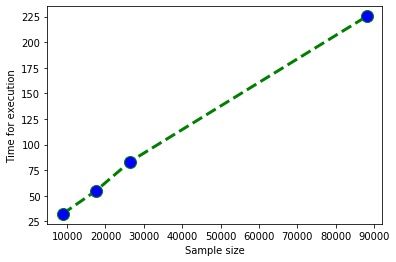

In [128]:
import matplotlib.pyplot as plt
sample_size=[8816,17532,26448,88162]
time_taken = [32.36,54.93,83.5,225.26]

plt.plot(sample_size, time_taken,   color='green', linestyle='dashed', linewidth = 3, 
         marker='o', markerfacecolor='blue', markersize=12) 

plt.xlabel('Sample size') 
plt.ylabel('Time for execution') 

In [118]:
# print_rules(Rule_Apriori)
# print_rules(Rules_randomized_10)
# print_rules(Rules_randomized_20)
print_rules(Rules_randomized_30)

{311} 	-->	 {49} 	 C:  66.12903225806451 	 L:  135.45389135387936 	 S:  0.018602540834845735
{226} 	-->	 {40} 	 C:  72.70114942528735 	 L:  125.06016260162602 	 S:  0.0286978221415608
{476} 	-->	 {49} 	 C:  65.45454545454545 	 L:  134.0723217303143 	 S:  0.016333938294010888
{311} 	-->	 {40} 	 C:  75.40322580645162 	 L:  129.70826121164438 	 S:  0.021211433756805807
{42} 	-->	 {49} 	 C:  60.44973544973544 	 L:  123.82083357919788 	 S:  0.10367513611615245
{49} 	-->	 {42} 	 C:  21.236059479553905 	 L:  123.8208335791979 	 S:  0.10367513611615245
{534} 	-->	 {40} 	 C:  59.25925925925925 	 L:  101.93748870822041 	 S:  0.010889292196007259
{256} 	-->	 {49} 	 C:  68.74999999999999 	 L:  140.82249070631968 	 S:  0.01247731397459165
{42} 	-->	 {90} 	 C:  5.886243386243387 	 L:  132.04356664916463 	 S:  0.010095281306715064
{90} 	-->	 {42} 	 C:  22.646310432569976 	 L:  132.0435666491646 	 S:  0.010095281306715064
{414} 	-->	 {49} 	 C:  63.49206349206349 	 L:  130.05251666961703 	 S:  0.013611

{40, 42} 	-->	 {39} 	 C:  26.82090831191088 	 L:  148.80624775192342 	 S:  0.035503629764065334
{42} 	-->	 {40, 39} 	 C:  20.7010582010582 	 L:  174.80893592004702 	 S:  0.035503629764065334
{42, 39} 	-->	 {40} 	 C:  78.25 	 L:  134.60526829268295 	 S:  0.035503629764065334
{39} 	-->	 {40, 42} 	 C:  19.697923222152298 	 L:  148.80624775192345 	 S:  0.035503629764065334
{40, 39} 	-->	 {42} 	 C:  29.980842911877392 	 L:  174.80893592004702 	 S:  0.035503629764065334
{49, 39} 	-->	 {33} 	 C:  22.596153846153843 	 L:  133.33848213366284 	 S:  0.02132486388384755
{33} 	-->	 {49, 39} 	 C:  12.58366800535475 	 L:  133.33848213366284 	 S:  0.02132486388384755
{33, 49} 	-->	 {39} 	 C:  23.707440100882724 	 L:  131.5322793765778 	 S:  0.02132486388384755
{33, 39} 	-->	 {49} 	 C:  62.046204620462056 	 L:  127.09092470585351 	 S:  0.02132486388384755
{39} 	-->	 {33, 49} 	 C:  11.831340465701699 	 L:  131.53227937657778 	 S:  0.02132486388384755
{40, 171} 	-->	 {39} 	 C:  100.0 	 L:  554.8143486469

In [123]:
j=[]
for i in range(len(transaction_list)):
    
    j +=transaction_list[i]

# [i for i in transaction_list]
# transaction_list[0]+transaction_list[1]
# len(list(set(j)))
len(transaction_list)

88162